# Battery Remaining Useful Life (RUL) Prediction with Random Forest
This notebook aims to predict the Remaining Useful Life (RUL) of batteries using a Random Forest model. The process includes:

1. Data Loading and Initial Cleaning
2. Exploratory Data Analysis (condensed)
3. Feature Selection and Preprocessing (including outlier handling and transformations)
4. Model Training
5. Model Evaluation
6. Feature Importance
7. Model Export

# 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import joblib
import warnings

In [2]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# 2. Load Data

In [3]:
try:
    df = pd.read_csv("../input/battery-remaining-useful-life-rul/Battery_RUL.csv")
except FileNotFoundError:
    print("Dataset file not found at ../input/battery-remaining-useful-life-rul/Battery_RUL.csv. Please check the path.")
    print("Attempting to load from local 'Battery_RUL.csv'...")
    try:
        df = pd.read_csv("Battery_RUL.csv")
        print("Successfully loaded 'Battery_RUL.csv' from local directory.")
    except FileNotFoundError:
        print("Local 'Battery_RUL.csv' not found. Please ensure the file is in the correct location.")
        # Exit or raise error if file is critical
        raise

Dataset file not found at ../input/battery-remaining-useful-life-rul/Battery_RUL.csv. Please check the path.
Attempting to load from local 'Battery_RUL.csv'...
Successfully loaded 'Battery_RUL.csv' from local directory.


## 3. Initial Data Preparation

In [4]:
print("Original DataFrame shape:", df.shape)

Original DataFrame shape: (15064, 9)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15064 entries, 0 to 15063
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Cycle_Index                15064 non-null  float64
 1   Discharge Time (s)         15064 non-null  float64
 2   Decrement 3.6-3.4V (s)     15064 non-null  float64
 3   Max. Voltage Dischar. (V)  15064 non-null  float64
 4   Min. Voltage Charg. (V)    15064 non-null  float64
 5   Time at 4.15V (s)          15064 non-null  float64
 6   Time constant current (s)  15064 non-null  float64
 7   Charging time (s)          15064 non-null  float64
 8   RUL                        15064 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.0 MB


In [6]:
print("\nOriginal DataFrame head:\n", df.head())


Original DataFrame head:
    Cycle_Index  Discharge Time (s)  Decrement 3.6-3.4V (s)  \
0          1.0             2595.30             1151.488500   
1          2.0             7408.64             1172.512500   
2          3.0             7393.76             1112.992000   
3          4.0             7385.50             1080.320667   
4          6.0            65022.75            29813.487000   

   Max. Voltage Dischar. (V)  Min. Voltage Charg. (V)  Time at 4.15V (s)  \
0                      3.670                    3.211           5460.001   
1                      4.246                    3.220           5508.992   
2                      4.249                    3.224           5508.993   
3                      4.250                    3.225           5502.016   
4                      4.290                    3.398           5480.992   

   Time constant current (s)  Charging time (s)   RUL  
0                    6755.01           10777.82  1112  
1                    6762.02   

In [8]:
print("\nOriginal DataFrame describe:\n", df.describe())


Original DataFrame describe:
         Cycle_Index  Discharge Time (s)  Decrement 3.6-3.4V (s)  \
count  15064.000000        15064.000000            15064.000000   
mean     556.155005         4581.273960             1239.784672   
std      322.378480        33144.012077            15039.589269   
min        1.000000            8.690000          -397645.908000   
25%      271.000000         1169.310000              319.600000   
50%      560.000000         1557.250000              439.239471   
75%      833.000000         1908.000000              600.000000   
max     1134.000000       958320.370000           406703.768000   

       Max. Voltage Dischar. (V)  Min. Voltage Charg. (V)  Time at 4.15V (s)  \
count               15064.000000             15064.000000       15064.000000   
mean                    3.908176                 3.577904        3768.336171   
std                     0.091003                 0.123695        9129.552477   
min                     3.043000             

Drop 'Cycle_Index' as it can lead to data leakage and is perfectly correlated with RUL if 'Cycle_Index' in df.columns:

In [9]:
if 'Cycle_Index' in df.columns:
    df.drop(columns='Cycle_Index', inplace=True)
    print("\nDropped 'Cycle_Index' column.")


Dropped 'Cycle_Index' column.


Drop the last row if it's a summary/total row (index 15063 as identified in original notebook)

In [10]:
df.drop(index=15063, inplace=True)
print("Dropped row with index 15063.")

print("\nDataFrame shape after initial drops:", df.shape)

Dropped row with index 15063.

DataFrame shape after initial drops: (15063, 8)


Rename columns for easier reference

In [11]:
original_cols = df.columns.tolist()

In [12]:
# Ensure RUL is the last column for new_col_labels if it's not already
if 'RUL' in original_cols:
    original_features = [col for col in original_cols if col != 'RUL']
    new_feature_labels = [f'F{i+1}' for i in range(len(original_features))]
    new_col_labels = new_feature_labels + ['RUL']
    
    if len(original_cols) == len(new_col_labels):
        df_column_dict = dict(zip(original_cols, new_col_labels))
        df.rename(columns=df_column_dict, inplace=True)
        print("\nColumns renamed:")
        print(df_column_dict)
    else:
        print("\nColumn length mismatch. Skipping renaming.")
else:
    print("\n'RUL' column not found. Skipping renaming based on RUL.")


Columns renamed:
{'Discharge Time (s)': 'F1', 'Decrement 3.6-3.4V (s)': 'F2', 'Max. Voltage Dischar. (V)': 'F3', 'Min. Voltage Charg. (V)': 'F4', 'Time at 4.15V (s)': 'F5', 'Time constant current (s)': 'F6', 'Charging time (s)': 'F7', 'RUL': 'RUL'}


In [13]:
print("\nDataFrame head after renaming:\n", df.head())


DataFrame head after renaming:
          F1            F2     F3     F4        F5        F6        F7   RUL
0   2595.30   1151.488500  3.670  3.211  5460.001   6755.01  10777.82  1112
1   7408.64   1172.512500  4.246  3.220  5508.992   6762.02  10500.35  1111
2   7393.76   1112.992000  4.249  3.224  5508.993   6762.02  10420.38  1110
3   7385.50   1080.320667  4.250  3.225  5502.016   6762.02  10322.81  1109
4  65022.75  29813.487000  4.290  3.398  5480.992  53213.54  56699.65  1107


Handle Duplicates

In [14]:
initial_rows = df.shape[0]
df.drop_duplicates(inplace=True)
rows_after_duplicates = df.shape[0]
print(f"\nDropped {initial_rows - rows_after_duplicates} duplicate rows.")
print(f"DataFrame shape after dropping duplicates: {df.shape}")


Dropped 39 duplicate rows.
DataFrame shape after dropping duplicates: (15024, 8)


Handle Negative Values

In [15]:
time_columns = []
if 'F1' in df.columns: time_columns.extend(['F1', 'F2', 'F5', 'F6', 'F7']) # Adjust if renaming failed or was different

# Filter out columns that are not present in df to avoid KeyError
valid_time_columns = [col for col in time_columns if col in df.columns]

if valid_time_columns:
    rows_before_neg_filter = df.shape[0]
    # Ensure columns are numeric before comparison
    for col in valid_time_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce') # Coerce errors to NaN
    df.dropna(subset=valid_time_columns, inplace=True) # Drop rows where conversion failed

    df = df[(df[valid_time_columns] >= 0).all(axis=1)]
    rows_after_neg_filter = df.shape[0]
    print(f"\nDropped {rows_before_neg_filter - rows_after_neg_filter} rows with negative values in time columns {valid_time_columns}.")
    print(f"DataFrame shape after handling negative time values: {df.shape}")
else:
    print("\nSkipping negative time value handling as relevant F-columns are not present (check renaming step).")


Dropped 33 rows with negative values in time columns ['F1', 'F2', 'F5', 'F6', 'F7'].
DataFrame shape after handling negative time values: (14991, 8)


## 4. Exploratory Data Analysis


DataFrame describe (post-cleaning):
                   F1             F2            F3            F4  \
count   14991.000000   14991.000000  14991.000000  14991.000000   
mean     4229.206765    1435.772970      3.907896      3.577714   
std     31465.065102   13763.906517      0.089842      0.122218   
min         8.690000      31.168831      3.043000      3.022000   
25%      1171.670000     320.666667      3.846000      3.488000   
50%      1557.500000     440.000000      3.906000      3.573000   
75%      1908.000000     601.210500      3.972000      3.663000   
max    958320.370000  406703.768000      4.363000      4.300000   

                  F5             F6             F7           RUL  
count   14991.000000   14991.000000   14991.000000  14991.000000  
mean     3681.977745    5290.314287    9900.930998    554.978587  
std      8821.961146   24095.322918   25446.019660    322.154045  
min        14.052000       5.980000       5.980000      0.000000  
25%      1836.343500   

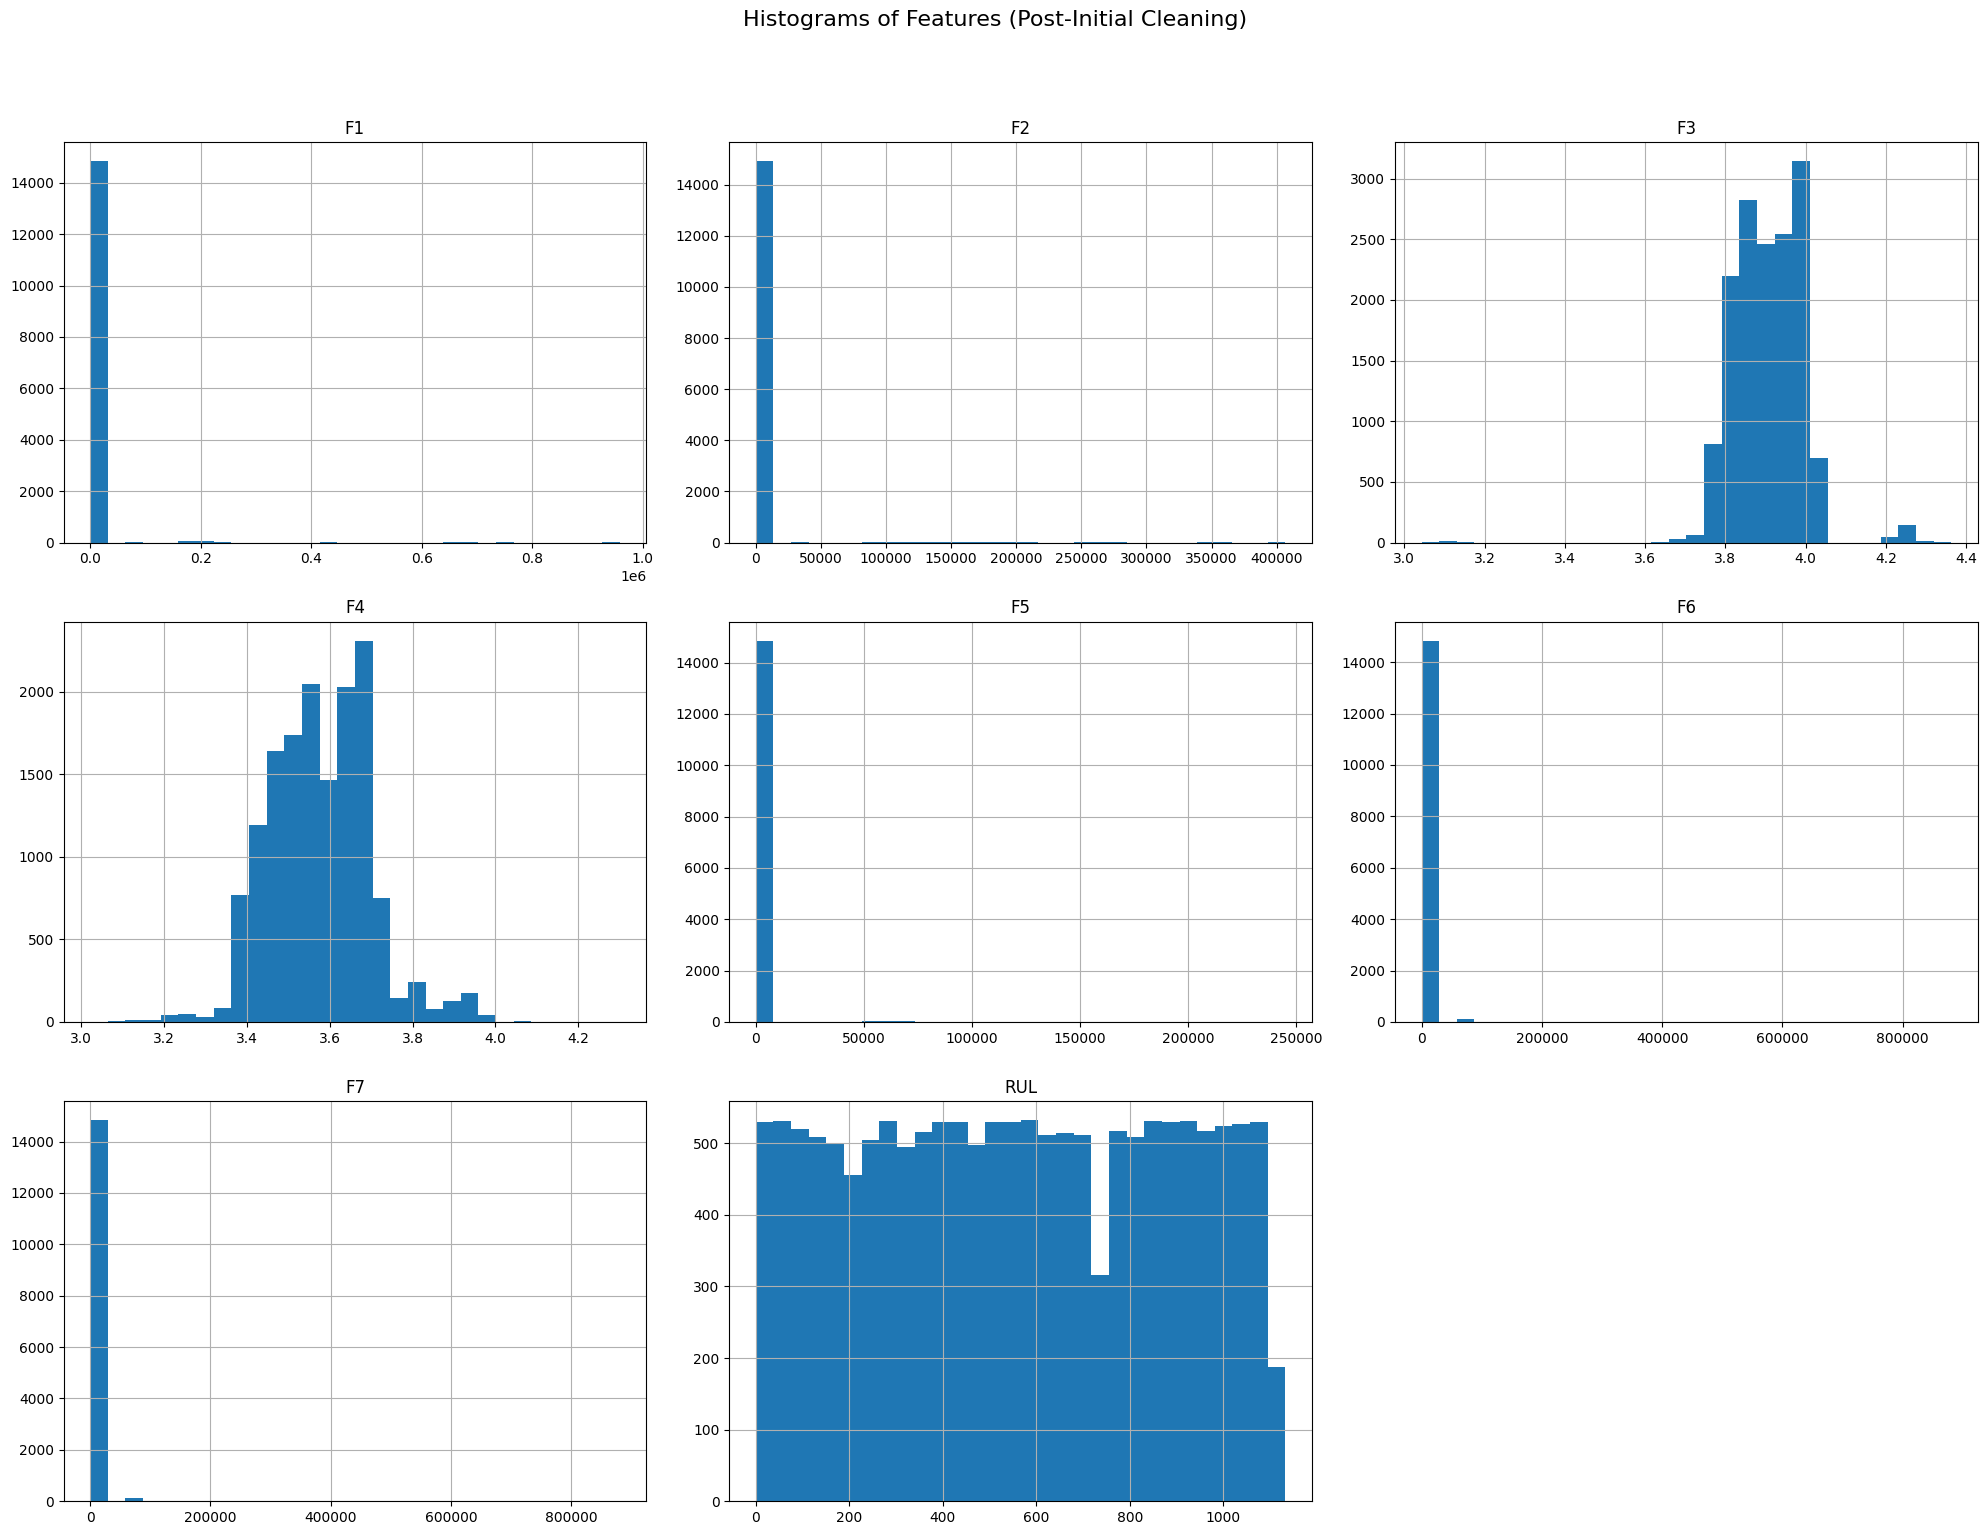

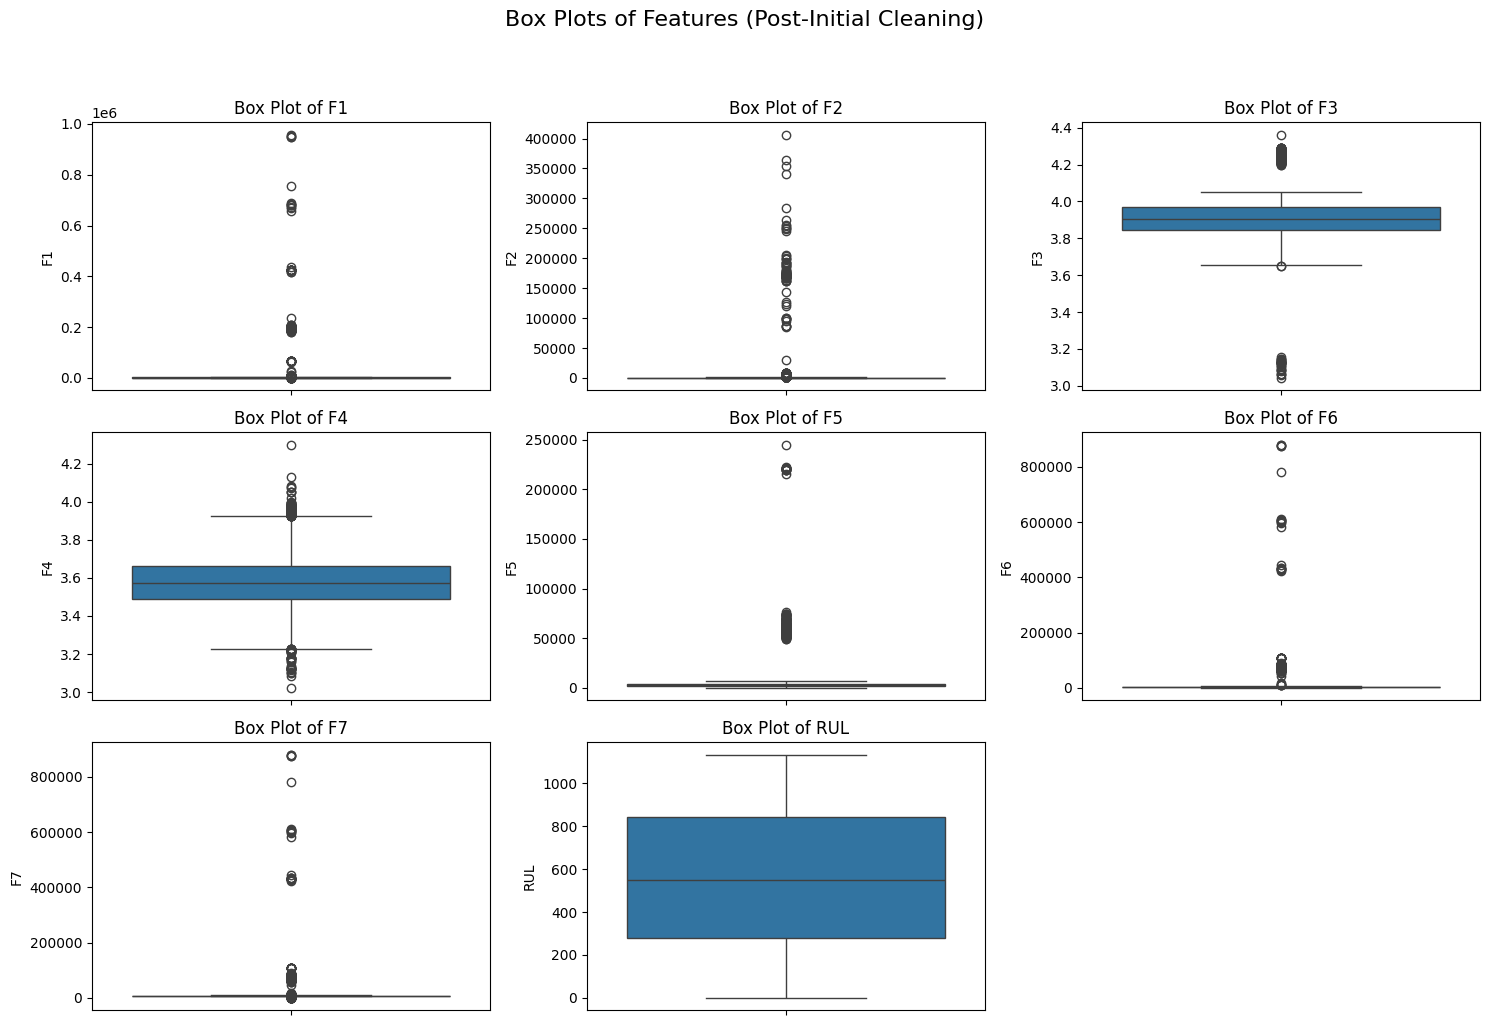

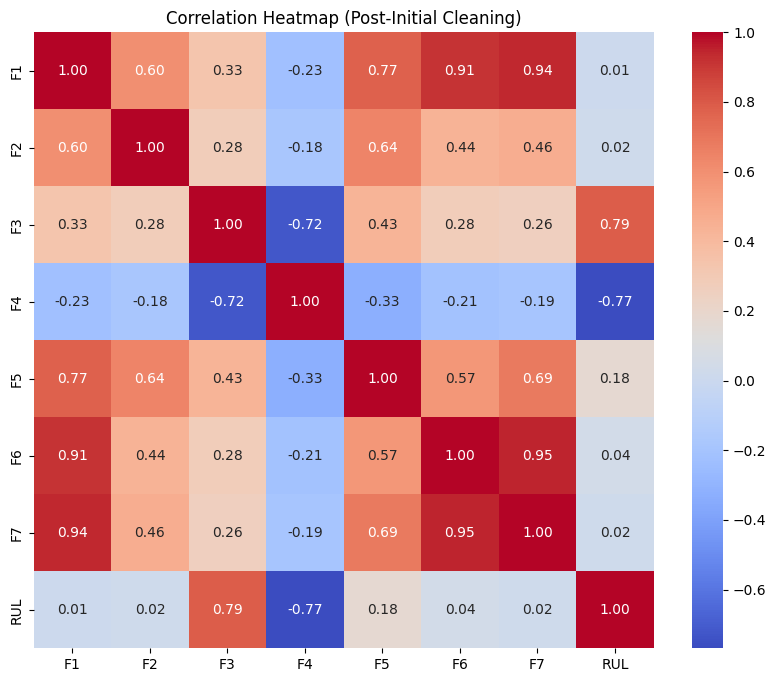

In [16]:
if not df.empty:
    print("\nDataFrame describe (post-cleaning):\n", df.describe())

    # Histograms
    df.hist(bins=30, figsize=(20, 15), layout=(-1, 3))
    plt.suptitle("Histograms of Features (Post-Initial Cleaning)", y=1.02, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

    # Box plots
    if len(df.columns) > 1 :
        num_cols_for_boxplot = min(len(df.columns), 9) # Limit to 9 plots for readability
        plt.figure(figsize=(15, 10))
        for i, col in enumerate(df.columns[:num_cols_for_boxplot]):
            plt.subplot(3, 3, i + 1)
            sns.boxplot(y=df[col])
            plt.title(f"Box Plot of {col}")
        plt.suptitle("Box Plots of Features (Post-Initial Cleaning)", y=1.02, fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.98])
        plt.show()

    # Correlation Heatmap
    plt.figure(figsize=(10, 8))
    # Ensure only numeric columns are used for correlation
    numeric_df_for_corr = df.select_dtypes(include=np.number)
    if not numeric_df_for_corr.empty:
        sns.heatmap(numeric_df_for_corr.corr(), annot=True, cmap='coolwarm', fmt=".2f")
        plt.title('Correlation Heatmap (Post-Initial Cleaning)')
        plt.show()
    else:
        print("No numeric columns found for correlation heatmap after cleaning.")
else:
    print("DataFrame is empty after initial cleaning. Cannot perform EDA.")


# 5. Feature Selection & Further Preprocessing
Based on original EDA insights (not fully reproduced here for brevity, but guiding the selection):
- `F3` (Max. Voltage Dischar. (V))
- `F4` (Min. Voltage Charg. (V))
- `F5` (Time at 4.15V (s))
were identified as potentially good candidates. `RUL` is the target.

In [17]:
potential_features = ['F3', 'F4', 'F5']
target_col = 'RUL'

In [18]:
selected_features = [col for col in potential_features if col in df.columns]

In [19]:
if not selected_features:
    print(f"Error: None of the potential features {potential_features} are in the DataFrame columns: {df.columns.tolist()}. Stopping.")
    # raise ValueError("Selected features not found in DataFrame.") # Or handle appropriately
    df_model = pd.DataFrame() # Empty df to avoid later errors
else:
    print(f"\nSelected features for modeling: {selected_features}")
    if target_col not in df.columns:
        print(f"Error: Target column '{target_col}' not found in DataFrame. Stopping.")
        # raise ValueError("Target column not found.")
        df_model = pd.DataFrame()
    else:
        df_model = df[selected_features + [target_col]].copy()
        print(f"Shape of df_model before outlier removal: {df_model.shape}")

# %% [code]


Selected features for modeling: ['F3', 'F4', 'F5']
Shape of df_model before outlier removal: (14991, 4)


Outlier Handling for Selected Features using IQR

In [20]:
if not df_model.empty:
    print("\nApplying IQR-based outlier removal to selected features...")
    for col in selected_features: # Iterate over F3, F4, F5
        if col in df_model.columns: # Ensure column exists
            Q1 = df_model[col].quantile(0.25)
            Q3 = df_model[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            rows_before = df_model.shape[0]
            df_model = df_model[(df_model[col] >= lower_bound) & (df_model[col] <= upper_bound)]
            rows_after = df_model.shape[0]
            print(f"  Feature '{col}': Removed {rows_before - rows_after} outliers. Shape is now {df_model.shape}")
        else:
            print(f"  Warning: Column {col} for outlier removal not found in df_model.")
    print(f"DataFrame shape after outlier removal: {df_model.shape}")
else:
    print("df_model is empty. Skipping outlier handling.")


Applying IQR-based outlier removal to selected features...
  Feature 'F3': Removed 232 outliers. Shape is now (14759, 4)
  Feature 'F4': Removed 230 outliers. Shape is now (14529, 4)
  Feature 'F5': Removed 0 outliers. Shape is now (14529, 4)
DataFrame shape after outlier removal: (14529, 4)


In [21]:
if df_model.empty or target_col not in df_model.columns or not selected_features:
    print("\nCannot proceed to model training due to missing data or features.")
else:
    # Split data into Features (X) and Target (y)
    X = df_model.drop(target_col, axis=1)
    y = df_model[target_col]

    print("\nShape of X (features):", X.shape)
    print("Shape of y (target):", y.shape)

    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print("\nShape of X_train:", X_train.shape)
    print("Shape of X_test:", X_test.shape)

    # Define column types for preprocessing
    # F5 (Time at 4.15V) was noted to be skewed and might benefit from PowerTransform.
    # F3, F4 are voltage metrics, StandardScaler is a good default.
    
    # Ensure the feature names match exactly what's in X_train.columns
    std_scale_features = [col for col in ['F3', 'F4'] if col in X_train.columns]
    power_transform_features = [col for col in ['F5'] if col in X_train.columns]
    
    transformers_list = []
    if std_scale_features:
        transformers_list.append(('std_scaler', StandardScaler(), std_scale_features))
    if power_transform_features:
        transformers_list.append(('power_transform', PowerTransformer(method='yeo-johnson'), power_transform_features))

    if not transformers_list:
        print("Warning: No features identified for scaling or transformation. Preprocessor will be empty.")
        # Create a "passthrough" preprocessor or handle this case as needed
        preprocessor = 'passthrough' 
    else:
        preprocessor = ColumnTransformer(transformers=transformers_list, remainder='passthrough')



Shape of X (features): (14529, 3)
Shape of y (target): (14529,)

Shape of X_train: (11623, 3)
Shape of X_test: (2906, 3)


# 6. Model Training (Random Forest)

In [22]:
# Assuming 'X_train', 'y_train', 'preprocessor' (as ColumnTransformer or string), 
# and 'transformers_list' are defined from the previous cell.

if 'X_train' not in locals() or X_train.empty:
    print("\nTraining data (X_train) is not available or empty. Skipping model training.")
else:
    # This 'else' means X_train is available and not empty.
    
    if not transformers_list: 
        # This case means transformers_list was empty, so no specific column transformations were defined.
        # 'preprocessor' might be the string 'passthrough' here, but we don't need it if we define a new pipeline.
        print("No specific column transformers defined (transformers_list is empty). Applying StandardScaler to all features as a default.")
        model_pipeline = Pipeline(steps=[
            ('scaler', StandardScaler()), 
            ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10, min_samples_split=5, oob_score=True)) # Added oob_score=True
        ])
    else: 
        # This case means transformers_list was NOT empty.
        # 'preprocessor' should be the ColumnTransformer object created earlier.
        print("Using defined ColumnTransformer for preprocessing.")
        model_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor), # 'preprocessor' is the ColumnTransformer object
            ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10, min_samples_split=5, oob_score=True))
        ])

    print("\nTraining Random Forest Regressor model...")
    model_pipeline.fit(X_train, y_train)
    print("Model training complete.")
    
    # Check and print OOB score if it was calculated
    current_regressor = model_pipeline.named_steps['regressor']
    if hasattr(current_regressor, 'oob_score') and current_regressor.oob_score: # Checks if oob_score parameter was True
        if hasattr(current_regressor, 'oob_score_'): # Checks if the attribute (result) exists
            print(f"OOB Score: {current_regressor.oob_score_:.4f}")
        else:
            # This should ideally not happen if oob_score=True and fit() has been called.
            print("OOB Score was set to True, but the oob_score_ attribute was not found.")

Using defined ColumnTransformer for preprocessing.

Training Random Forest Regressor model...
Model training complete.
OOB Score: 0.9882


# 7. Model Evaluation


Evaluating model performance...
Mean Absolute Error (MAE): 22.27
Mean Squared Error (MSE): 1158.75
Root Mean Squared Error (RMSE): 34.04
R-squared (R²): 0.9888


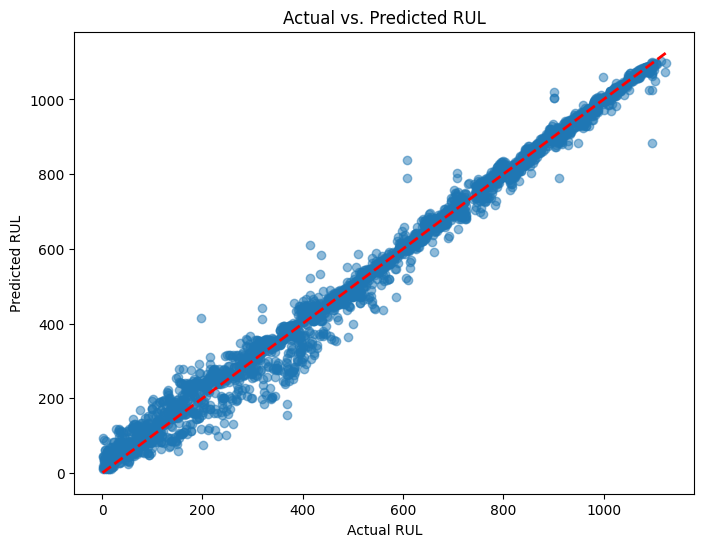

In [23]:
if 'model_pipeline' in locals() and 'X_test' in locals() and not X_test.empty:
    print("\nEvaluating model performance...")
    y_pred = model_pipeline.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R-squared (R²): {r2:.4f}")

    # Scatter plot of Actual vs. Predicted values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
    plt.xlabel("Actual RUL")
    plt.ylabel("Predicted RUL")
    plt.title("Actual vs. Predicted RUL")
    plt.show()
else:
    print("\nModel or test data not available. Skipping model evaluation.")

# 8. Feature Importance


Extracting and displaying feature importances...

Feature Importances:
                Feature  Importance
2  power_transform__F5    0.980336
0       std_scaler__F3    0.013512
1       std_scaler__F4    0.006152


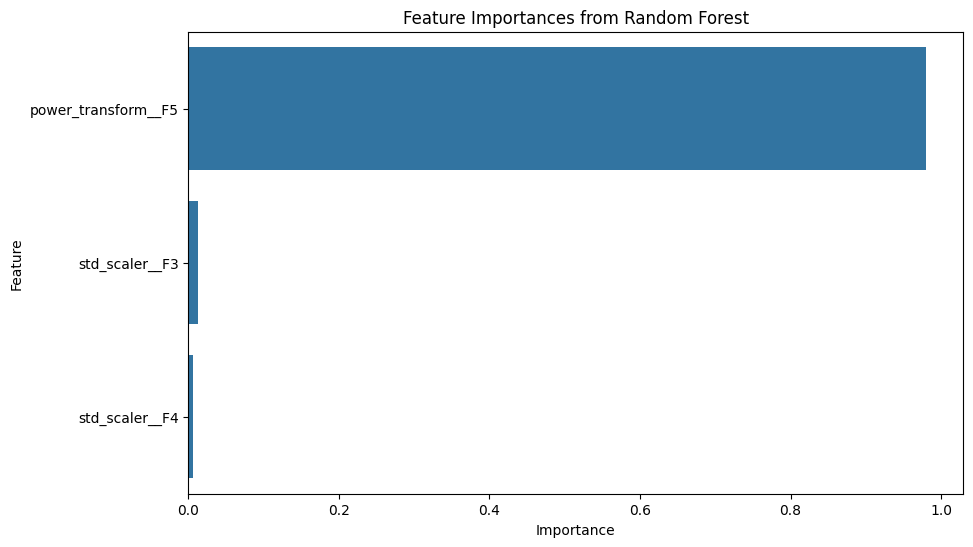

In [24]:
if 'model_pipeline' in locals() and 'regressor' in model_pipeline.named_steps and hasattr(model_pipeline.named_steps['regressor'], 'feature_importances_'):
    print("\nExtracting and displaying feature importances...")
    
    try:
        # Get feature names after transformation by ColumnTransformer
        # The 'preprocessor' step in the pipeline is the ColumnTransformer
        # If a simple scaler was used directly, X_train.columns are the names.
        if 'preprocessor' in model_pipeline.named_steps and isinstance(model_pipeline.named_steps['preprocessor'], ColumnTransformer):
            feature_names_transformed = model_pipeline.named_steps['preprocessor'].get_feature_names_out()
        elif 'scaler' in model_pipeline.named_steps: # If a simple scaler was used
             feature_names_transformed = X_train.columns.tolist()
        else: # Fallback if preprocessor structure is unexpected
            feature_names_transformed = X_train.columns.tolist()


        importances = model_pipeline.named_steps['regressor'].feature_importances_
        
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names_transformed,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)

        print("\nFeature Importances:\n", feature_importance_df)

        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
        plt.title('Feature Importances from Random Forest')
        plt.show()
        
    except Exception as e:
        print(f"Could not retrieve feature names from ColumnTransformer: {e}")
        print("Displaying importances with generic names based on X_train.columns:")
        importances = model_pipeline.named_steps['regressor'].feature_importances_
        feature_names_original = X_train.columns.tolist() # Original feature names before transformation

        if len(importances) == len(feature_names_original):
            feature_importance_df = pd.DataFrame({
                'Feature': feature_names_original,
                'Importance': importances
            }).sort_values(by='Importance', ascending=False)
            print("\nFeature Importances (using original feature names):\n", feature_importance_df)
            plt.figure(figsize=(10, 6))
            sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
            plt.title('Feature Importances from Random Forest (Original Features)')
            plt.show()
        else:
            print(f"Mismatch between number of importances ({len(importances)}) and original feature names ({len(feature_names_original)}).")


else:
    print("\nModel or feature importances not available. Skipping feature importance display.")


# 9. Model Export

In [25]:
if 'model_pipeline' in locals():
    model_filename = 'rul_model_pipeline.joblib'
    joblib.dump(model_pipeline, model_filename)
    print(f"\nTrained model pipeline saved to '{model_filename}'")
else:
    print("\nModel not trained. Skipping model export.")


Trained model pipeline saved to 'rul_model_pipeline.joblib'


In [27]:
# Check if model_pipeline exists and X_train (to get column order)
if 'model_pipeline' in locals() and 'X_train' in locals() and not X_train.empty:
    # --- User Input Section ---
    # Modify these values to test with your own data
    # You can get an idea of typical ranges from df_model.describe() before splitting
    # or from X_test.describe()
    
    # Let's print describe of X_train to give user an idea of typical values
    print("--- Feature Value Guidance (from Training Data X_train) ---")
    print(X_train.describe())
    print("-" * 50)
    
    print("\nEnter your custom feature values below:")
    # Example: Taking mean values from X_train.describe() as defaults
    # You should replace these with your actual test values
    default_f3 = X_train['F3'].mean() 
    default_f4 = X_train['F4'].mean()
    default_f5 = X_train['F5'].mean()

    # Use input() for interactive input, or set manually
    try:
        input_f3 = float(input(f"Enter value for F3 (Max. Voltage Dischar. (V)) [e.g., {default_f3:.2f}]: ") or default_f3)
        input_f4 = float(input(f"Enter value for F4 (Min. Voltage Charg. (V))  [e.g., {default_f4:.2f}]: ") or default_f4)
        input_f5 = float(input(f"Enter value for F5 (Time at 4.15V (s))     [e.g., {default_f5:.0f}]: ") or default_f5)
    except ValueError:
        print("Invalid input. Please enter numeric values. Using mean values as default for this test run.")
        input_f3 = default_f3
        input_f4 = default_f4
        input_f5 = default_f5

    custom_input_values = {
        'F3': input_f3,
        'F4': input_f4,
        'F5': input_f5
    }
    # --- End User Input Section ---

    # Create a DataFrame from the custom input
    # The order of columns should match the order seen by the model during training
    # X_train.columns will give ['F3', 'F4', 'F5'] in the correct order
    custom_input_df = pd.DataFrame([custom_input_values], columns=X_train.columns)

    print("\n--- Custom Input DataFrame ---")
    print(custom_input_df)
    print("-" * 50)

    # Use the trained pipeline to make a prediction
    # The pipeline will handle preprocessing (scaling, transformation)
    predicted_rul = model_pipeline.predict(custom_input_df)

    print("\n--- Prediction ---")
    print(f"Predicted RUL: {predicted_rul[0]:.0f} cycles")
    print("-" * 50)

else:
    print("\nModel pipeline or X_train is not available. Please train the model first (run up to section 6).")

--- Feature Value Guidance (from Training Data X_train) ---
                 F3            F4            F5
count  11623.000000  11623.000000  11623.000000
mean       3.905972      3.576440   2991.233039
std        0.073192      0.108379   1221.117307
min        3.674000      3.355000    471.906000
25%        3.848000      3.492000   1859.784071
50%        3.906000      3.573000   2936.344000
75%        3.970000      3.661000   4061.913000
max        4.053000      3.917000   6826.609250
--------------------------------------------------

Enter your custom feature values below:

--- Custom Input DataFrame ---
         F3       F4           F5
0  3.905972  3.57644  2991.233039
--------------------------------------------------

--- Prediction ---
Predicted RUL: 567 cycles
--------------------------------------------------
